
## **CS146 Final Project**
## Prof. Scheffler
### Anirudh Nair


In [1]:
#importing the required libraries
import pystan
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as sts
from scipy.optimize import curve_fit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
from datetime import datetime,timedelta
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Loading and Preprocessing

In [3]:
#importing the data from the given dataset
data = pd.read_csv('weekly_in_situ_co2_mlo (1).csv',names=['Dates','CO2'], skiprows=44)

When preprocessing the date values, we subtract each value from the first date and multiply them by a factor of 1461 (365.25*4 = 1461 days = 4 years) to normalize the entire array of date values. This allows for more well suited parameter values for the Stan Inference.

In [7]:
#preprocessing the data by storing the date values relative to the first instance of data collection
firstdate = data['Dates'][0]
data['Dates'] = data.apply(lambda x:(abs((datetime.strptime(firstdate, "%Y-%m-%d") - datetime.strptime(x['Dates'], "%Y-%m-%d")).days))/1461, axis = 1)

In [8]:
#previewing the pandas dataframe created
data.head()

,Dates,CO2
0,0.000000,316.19
1,0.004791,317.31
2,0.009582,317.69
3,0.014374,317.58
4,0.019165,316.48


# Plotting the Preprocessed data

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


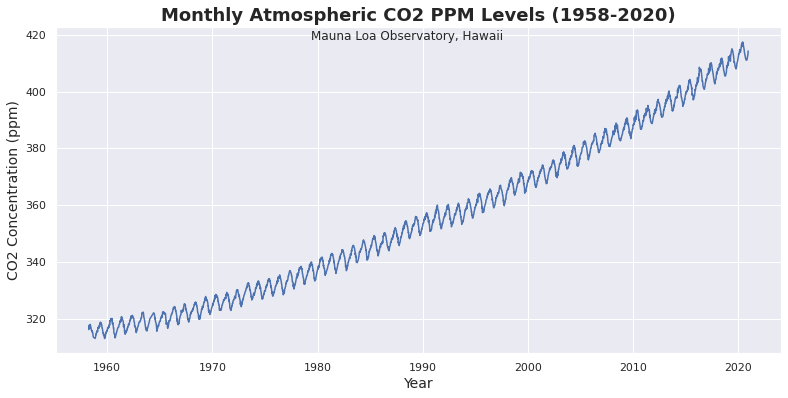

In [9]:
#plotting the data acquired to inspect CO2 PPM levels.
plt.figure(figsize=(13,6))
plt.plot(data['Dates']*4+1958.25, data['CO2'])
plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Concentration (ppm)', fontsize=14)
plt.title('Monthly Atmospheric CO2 PPM Levels (1958-2020)', fontsize=18, weight='semibold')
plt.figtext(.5,.85,'Mauna Loa Observatory, Hawaii', fontsize=12, ha='center')
plt.show()

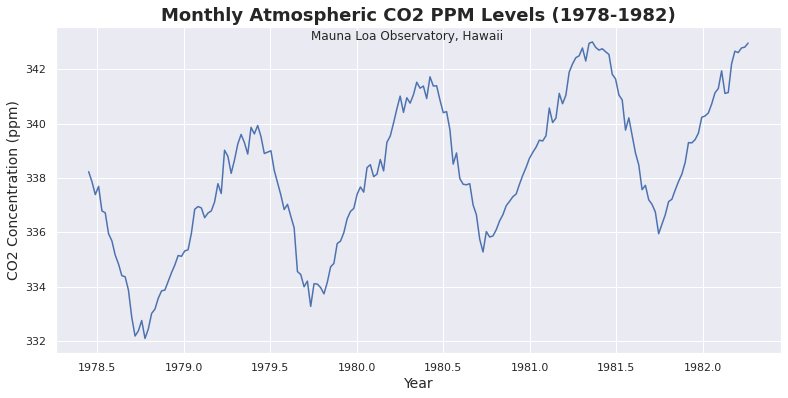

In [154]:
#plotting the data acquired to inspect CO2 PPM levels.
plt.figure(figsize=(13,6))
plt.plot(data['Dates'][1000:1200]*4+1958.25, data['CO2'][1000:1200])
plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Concentration (ppm)', fontsize=14)
plt.title('Monthly Atmospheric CO2 PPM Levels (1978-1982)', fontsize=18, weight='semibold')
plt.figtext(.5,.85,'Mauna Loa Observatory, Hawaii', fontsize=12, ha='center')
plt.show()

#Defining continously used functions
We begin my creating a set of functions that will be constantly used throughout the inference process to inspect the fit and performance of the model. 

In [10]:
# Plot sample autocorrelation for each parameter.
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

#display acf plots
def display_acf_plots(posterior_samples,parameters):
    plt.figure(figsize=(18, 16))
    for param in range(len(parameters)):
        #accomodate up to 12 param plots in a neat format
        plt.subplot(4,3,param + 1)
        plot_acf(posterior_samples[parameters[param]])
        plt.title(f'Autocorrelation of {parameters[param]} samples')
    plt.show()

In [11]:
# Make pair plot of the posteriors over all parameters of the model.
def pair_plots(posterior_samples,parameters):
    df = pd.DataFrame(
        data=np.transpose([posterior_samples[param] for param in parameters]),
        columns=parameters)
    sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

In [139]:
def plot_model(model_name,model_mean):
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,2,1)
    plt.plot(data['Dates']*4+1958.25, data['CO2'],label='Observed data')
    plt.plot(days*4+1958.25,model_mean,color="coral",label='Model data',linewidth=0.6)
    plt.xlabel('Year')
    plt.ylabel('CO2 PPM')
    plt.legend(prop={'size': 15})
    plt.title(f'{model_name} Model vs Observed Data: Mean CO2 PPM',fontsize=15)
    
    #plot close-up of model vs observed data
    plt.subplot(1,2,2)
    plt.plot(data['Dates'][2000:2500]*4+1958.25, data['CO2'][2000:2500], label='Observed data')
    plt.plot(days[2000:2500]*4+1958.25, model_mean[2000:2500],color="coral",label='Model data',linewidth=1)
    plt.xlabel('Year')
    plt.ylabel('CO2 PPM')
    plt.legend(prop={'size': 15})
    plt.title(f'Close-up of {model_name} Model vs Observed Data',fontsize=15)
    
    plt.show()

In [140]:
#calculate absolute error per day averaged over 4000 samples
def abs_err_train(replicated_data):
    return [np.mean(abs(data['CO2'].values[i]-replicated_data[:,i])) for i in range(2000)]

def abs_err_test(replicated_data):
    return [np.mean(abs(data['CO2'].values[i]-replicated_data[:,i])) for i in range(len(data['CO2'].values)-2000)]


#calculate root mean squared error of model from 4000 samples
def rmse(replicated_data):
    return [np.mean(np.sqrt((data['CO2'].values - replicated_data[i,:])**2)) for i in range(len(replicated_data))] 


def plot_errors_train(model_name, replicated_data):

    train_abs_err = abs_err_train(replicated_data)
    train_rmse = rmse(replicated_data[0:2000])
    avg_train_rmse = np.mean(train_rmse)

    plt.figure(figsize = (20,4))
    plt.subplot(1,2,1)
    plt.plot(days[0:2000]*4+1958.25,train_abs_err)
    plt.title(f'Absolute error of {model_name} model training samples over observed timeframe')
    plt.xlabel('Year')
    plt.ylabel('CO2 PPM')

    plt.subplot(1,2,2)
    plt.hist(train_rmse)
    plt.title(f'Distribution of Root Mean Squared Error between {model_name} model training samples and real data')
    plt.xlabel(f'Average Training Root Mean Squared Error: {avg_train_rmse}')


def plot_errors_test(model_name,replicated_data):
    
    test_abs_err = abs_err_test(replicated_data)
    test_rmse = rmse(replicated_data[2000:len(replicated_data)])
    avg_test_rmse = np.mean(test_rmse)

    plt.figure(figsize = (20,4))
    plt.subplot(1,2,1)
    plt.plot(days[2000:len(replicated_data)]*4+1958.25,test_abs_err)
    plt.title(f'Absolute error of {model_name} model testing samples over observed timeframe')
    plt.xlabel('Year')
    plt.ylabel('CO2 PPM')

    plt.subplot(1,2,2)
    plt.hist(test_rmse)
    plt.title(f'Distribution of Root Mean Squared Error between {model_name} model testing samples and real data')
    plt.xlabel(f'Average Testing Root Mean Squared Error: {avg_test_rmse}')

In [126]:
days[1]

0.004791238877481177

# Linear Model (From the Example)


In [16]:
#compiling the input data that will be fed into all stan models hereon
stan_data = {
                'N': len(data['Dates'].values[:2000]), 
                'co2': data['CO2'].values[:2000],
                'day': data['Dates'].values[:2000]
            }

In [17]:
linear_model_stan = """

data {  
    // length of the data collected
    int<lower=0> N;           
    
    // the data
    vector[N] co2; 
    vector[N] day;
}

parameters {
    // noise
    real <lower=0> sigma; 
    
    //long term trend parameters (constant and coefficient for t)
    real c_0;
    real c_1;
    
    //seasonal variation parameter (amplitude)
    real<lower=0> c_2;
    
    //phase
    real<lower=-pi(), upper=pi()> phi;
}

model {
    //random noise from normal distribution
    sigma ~ gamma(1, 0.2);
    
    //priors for the different parameters of our model
    c_0 ~ normal(300, 100);    
    c_1 ~ normal(0, 5);
    c_2 ~ normal(0, 5);
    phi ~ normal(0, pi()/2);

    //likelihood function from the example

    for(i in 1:N) {
        co2[i] ~ normal(c_0 + c_1*day[i] + c_2*cos(2*pi()*day[i]/365.25 + phi), sigma);
  }
}

"""
linear_model = pystan.StanModel(model_code=linear_model_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2b5447c8b6bc006d5bdd206e3e7b00de NOW.


In [18]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
linear_model_results= linear_model.sampling(data=stan_data)
print(linear_model_results)

Inference for Stan model: anon_model_2b5447c8b6bc006d5bdd206e3e7b00de.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   2.64  3.7e-3   0.04   2.55   2.61   2.64   2.66   2.72    134   1.04
c_0   342.06   13.57  21.07 307.32  314.0 348.62 357.53 372.59      2    2.4
c_1     5.28    0.04   0.12   5.13   5.19   5.24   5.35   5.56     10   1.16
c_2    33.38   12.92  20.16    0.3   12.3  39.39   48.4  62.89      2   2.34
phi     2.04    1.04   1.51  -1.17   1.17   2.85    3.0   3.12      2   7.45
lp__   -2952    2.94    4.4  -2960  -2957  -2950  -2948  -2947      2   2.98

Samples were drawn using NUTS at Sat Dec 26 19:23:53 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [28]:
# Extract the generated samples from the stan model
linear_samples = linear_model_results.extract()

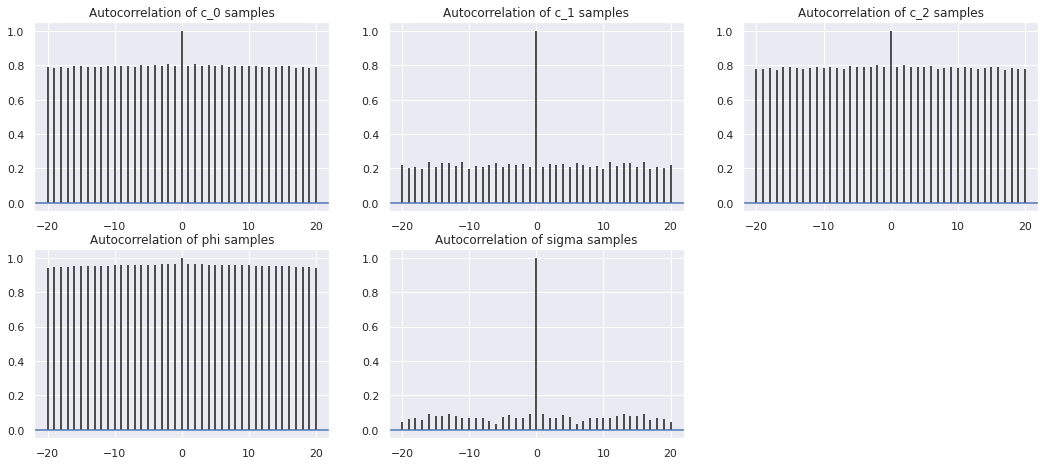

In [29]:
#autocorrelation plots
linear_param = ['c_0', 'c_1', 'c_2','phi','sigma']
display_acf_plots(linear_samples,linear_param)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


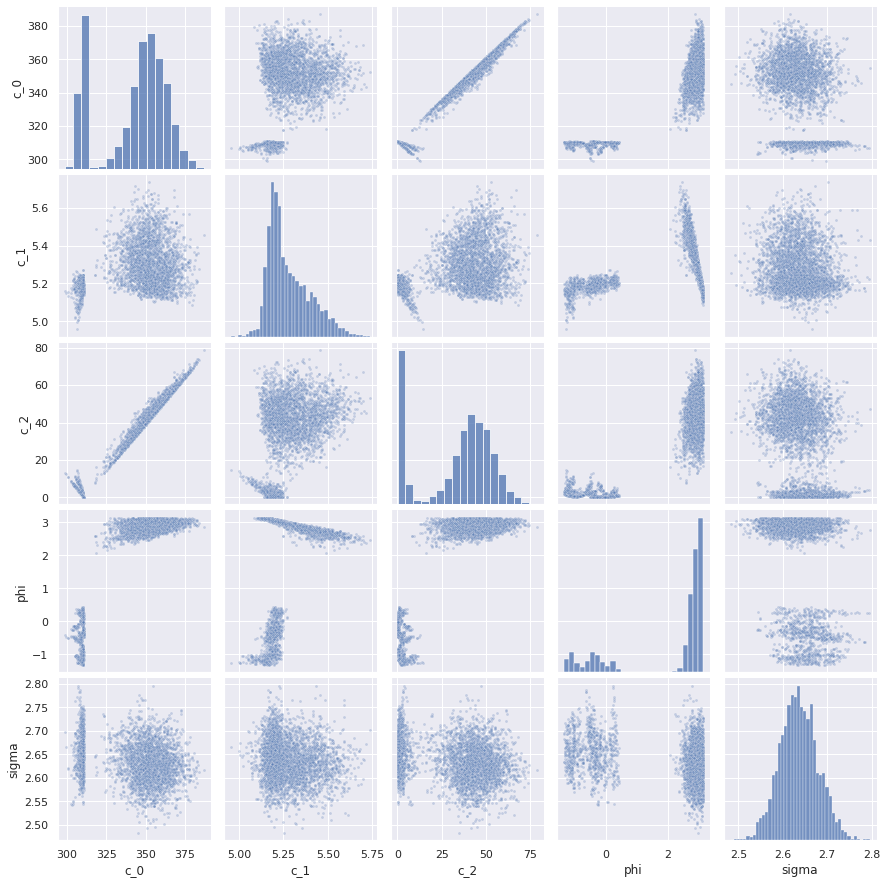

In [30]:
#pair plots
pair_plots(linear_samples,linear_param)

In [31]:
def linear_model_sampler(posterior_samples,time_range,f,args=0):
    return np.array(sts.norm.rvs(f(posterior_samples['c_0'],args) + f(posterior_samples['c_1'],args)*time_range
                    + f(posterior_samples['c_2'],args)*np.cos((2*np.pi*time_range)/365.25 + f(posterior_samples['phi'],args)),
                    np.mean(posterior_samples['sigma'])))

In [32]:
days = np.array(data['Dates'].values)

In [33]:
#linear model sample data
linear_mean = linear_model_sampler(linear_samples,days,np.mean)
linear_lower_interval = linear_model_sampler(linear_samples,days,np.percentile,2.5)
linear_upper_interval = linear_model_sampler(linear_samples,days,np.percentile,97.5)

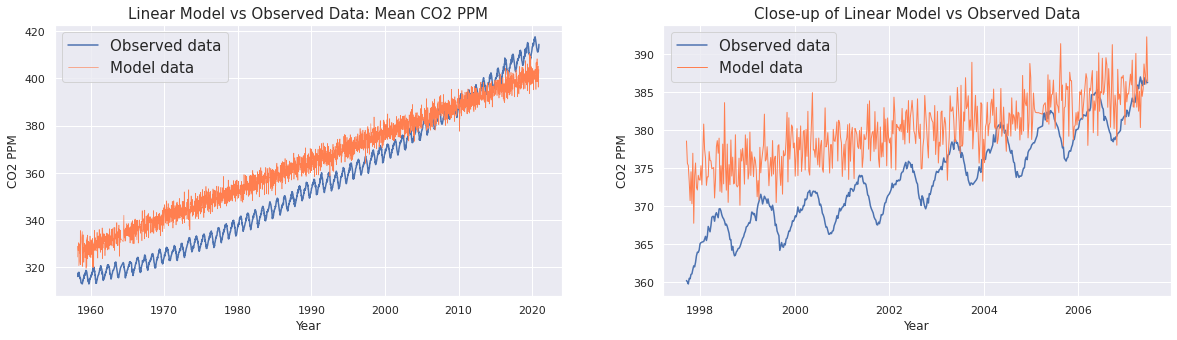

In [141]:
#Plot of linear model vs observed data
plot_model('Linear',linear_mean)

In [35]:
linear_rep = np.zeros((4000,len(days)))

for i in range(4000):
    linear_rep[i,:] = sts.norm.rvs(
                        linear_samples['c_0'][i] + linear_samples['c_1'][i]*days 
                        + linear_samples['c_2'][i]*np.cos((2*np.pi*days)/365.25 + linear_samples['phi'][i]),
                        linear_samples['sigma'][i])

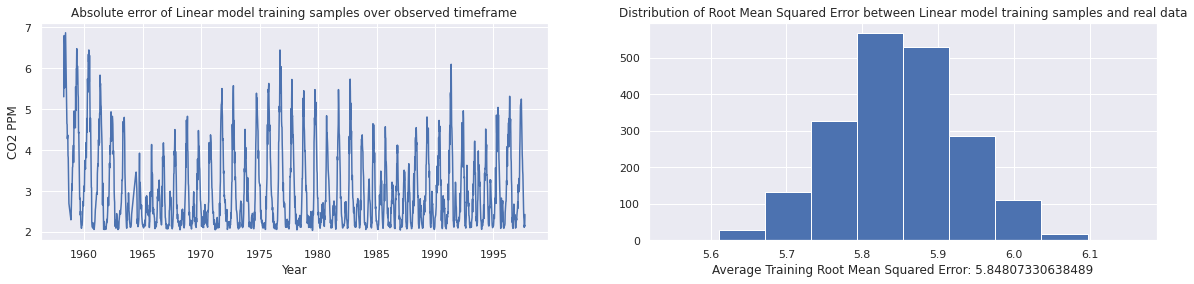

In [142]:
plot_errors_train('Linear',linear_rep)

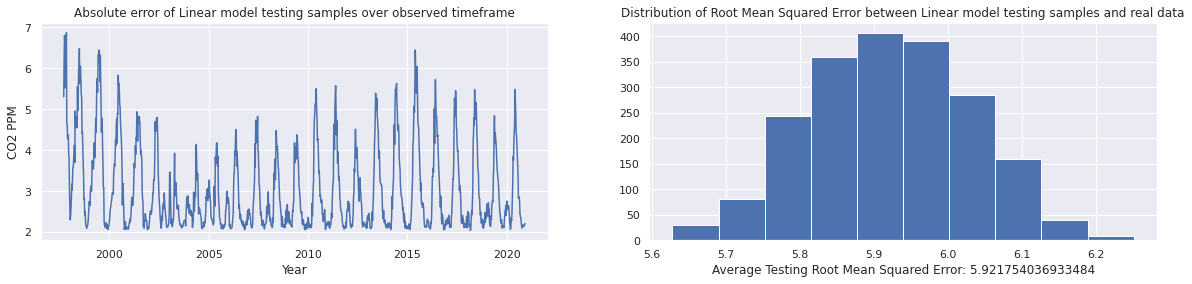

In [143]:
plot_errors_test('Linear',linear_rep)

# Quadratic Model

In [37]:
quadratic_model_stan = """

data {  
    // length of the data collected
    int<lower=0> N;           
    
    // the data
    vector[N] co2; 
    vector[N] day;
}

parameters {
    // noise
    real <lower=0> sigma; 
    
    //long term trend parameters (offset and coefficient for t)
    real c_0;
    real c_1;
    
    //seasonal variation parameter (amplitude)
    real<lower=0> c_2;
    
    //phase
    real<lower=-pi(), upper=pi()> phi;
}

model {
    //random noise from normal distribution
    sigma ~ gamma(1, 0.2);
    
    //priors for the different parameters of our model
    c_0 ~ normal(300, 100);    
    c_1 ~ normal(0, 2);
    c_2 ~ normal(0, 5);
    phi ~ normal(0, pi()/2);

    //likelihood function from the example

    for(i in 1:N) {
        co2[i] ~ normal(c_0 + c_1*day[i]^2 + c_2*cos(2*pi()*day[i]/365.25 + phi), sigma);
  }
}

"""
quadratic_model = pystan.StanModel(model_code=quadratic_model_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e089840daa8beec3b4ac415feae7a721 NOW.


In [38]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
quadratic_model_results= quadratic_model.sampling(data=stan_data)
print(quadratic_model_results)

Inference for Stan model: anon_model_e089840daa8beec3b4ac415feae7a721.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   2.21  3.3e-3   0.04   2.14   2.18   2.21   2.23   2.28    122   1.03
c_0    314.7    0.43   9.99 296.13 307.88 314.75 321.14 335.31    530   1.01
c_1     0.25  2.6e-4 6.4e-3   0.24   0.25   0.25   0.26   0.27    590   1.01
c_2   154.59    0.14   3.78 147.29 151.94 154.64  157.2  161.9    686    1.0
phi    -1.57  2.8e-3   0.06   -1.7  -1.61  -1.57  -1.52  -1.45    527   1.01
lp__   -2704    0.06   1.58  -2708  -2705  -2704  -2703  -2702    732   1.01

Samples were drawn using NUTS at Sat Dec 26 19:47:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [39]:
# Extract the generated samples from the stan model
quadratic_samples = quadratic_model_results.extract()

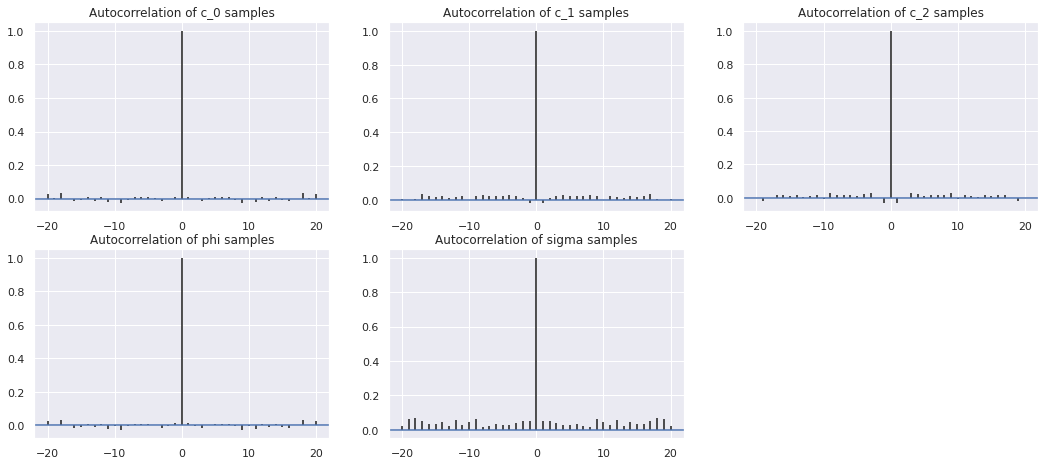

In [40]:
#autocorrelation plots
quadratic_param = ['c_0', 'c_1', 'c_2','phi','sigma']
display_acf_plots(quadratic_samples,quadratic_param)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


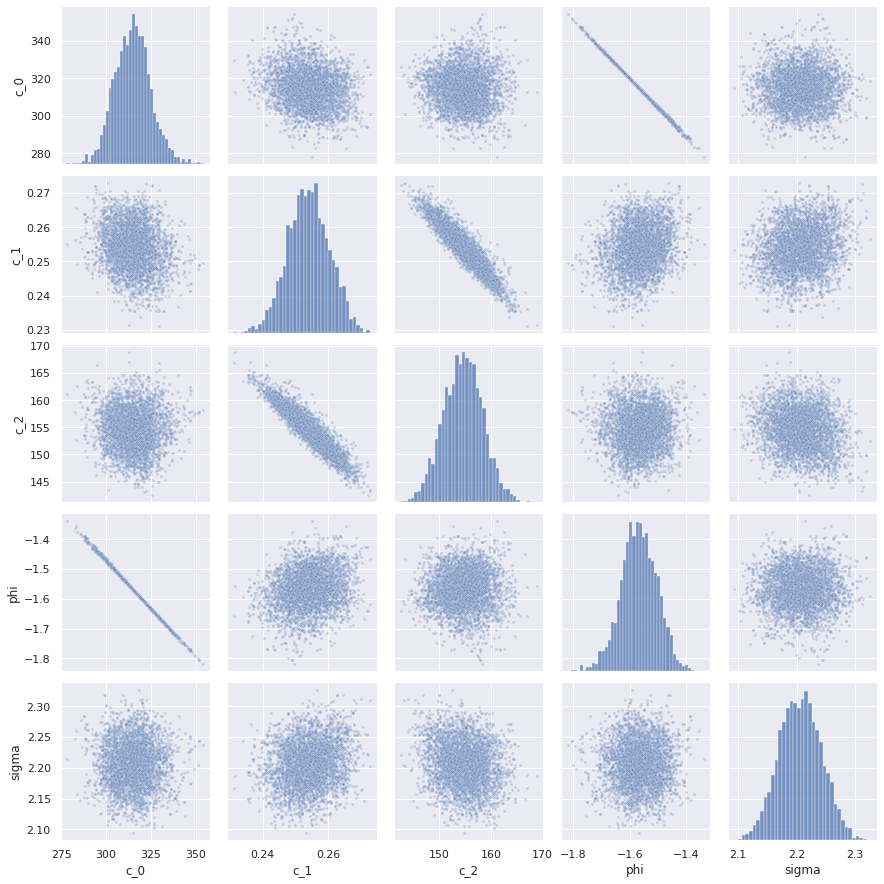

In [41]:
#pair plots
pair_plots(quadratic_samples,quadratic_param)

In [42]:
def quadratic_model_sampler(posterior_samples,time_range,f,args=0):
    return np.array(sts.norm.rvs(f(posterior_samples['c_0'],args) + f(posterior_samples['c_1'],args)*(time_range**2)
                    + f(posterior_samples['c_2'],args)*np.cos((2*np.pi*time_range)/365.25 + f(posterior_samples['phi'],args)),
                    np.mean(posterior_samples['sigma'])))

In [43]:
#quadratic model sample data
quadratic_mean = quadratic_model_sampler(quadratic_samples,days,np.mean)
quadratic_lower_interval = quadratic_model_sampler(quadratic_samples,days,np.percentile,2.5)
quadratic_upper_interval = quadratic_model_sampler(quadratic_samples,days,np.percentile,97.5)

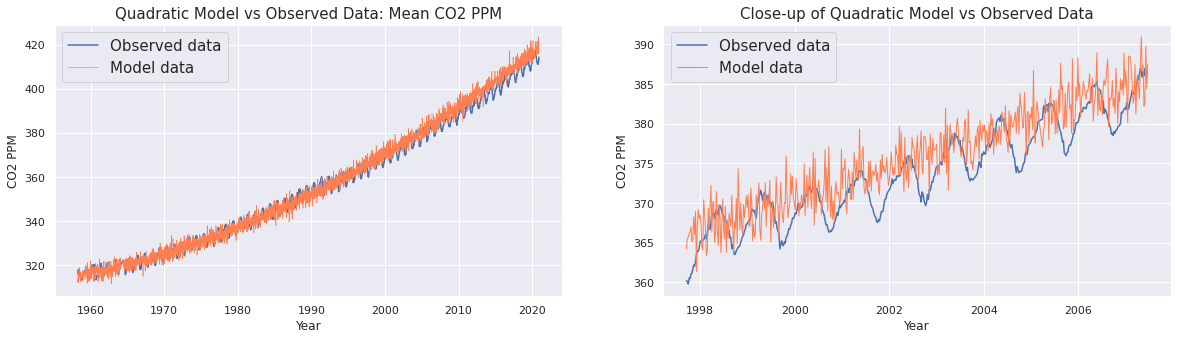

In [144]:
#Plot of linear model vs observed data
plot_model('Quadratic',quadratic_mean)

In [45]:
quadratic_rep = np.zeros((4000,len(days)))

for i in range(4000):
    quadratic_rep[i,:] = sts.norm.rvs(
                        quadratic_samples['c_0'][i] + quadratic_samples['c_1'][i]*(days**2)
                        + quadratic_samples['c_2'][i]*np.cos((2*np.pi*days)/365.25 + quadratic_samples['phi'][i]),
                        quadratic_samples['sigma'][i])

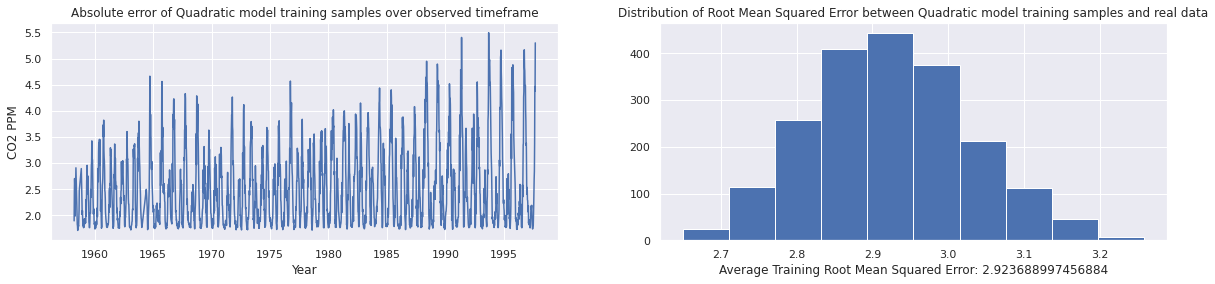

In [145]:
plot_errors_train('Quadratic',quadratic_rep)

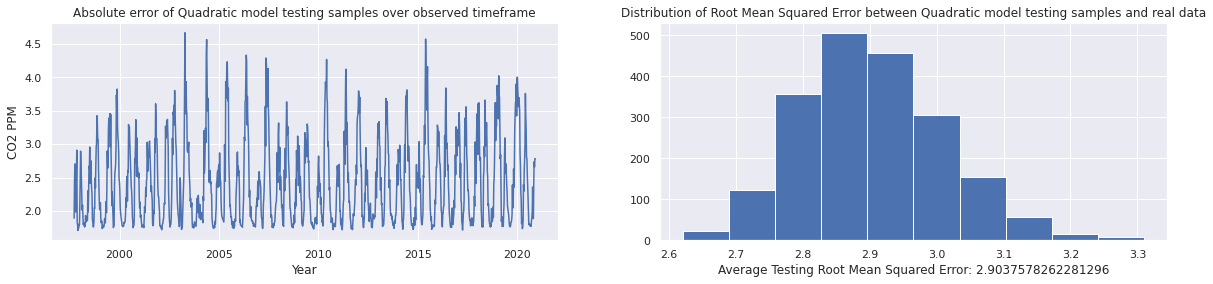

In [146]:
plot_errors_test('Quadratic',quadratic_rep)

# Linear Quadratic Model

In [47]:
linear_quadratic_model_stan = """

data {  
    // length of the data collected
    int<lower=1> N;           
    
    // the data
    vector[N] co2; 
    vector[N] day;
}

parameters {
    // noise
    real sigma; 
    
    //long term trend parameters (offset and coefficient for t)
    real c_0;
    real c_1;
    real c_2;
    
    //seasonal variation parameter (amplitude)
    real<lower=0> c_3;
    
    //phase
    real<lower=-pi(), upper=pi()> phi;
}

model {
    //random noise from normal distribution
    sigma ~ gamma(1, 0.2);
    
    //priors for the different parameters of our model
    c_0 ~ normal(300, 100);    
    c_1 ~ normal(0, 2);
    c_2 ~ normal(0, 2);
    c_3 ~ normal(0, 5);
    phi ~ normal(0, pi()/2);
    //likelihood function from the example

    for(i in 1:N) {
        co2[i] ~ normal(c_0 + c_1*(day[i]) + c_2*(day[i]^2) + c_3*cos((2*pi()*day[i]*4)+ phi), sigma);
  }
}

"""
linear_quadratic_model = pystan.StanModel(model_code=linear_quadratic_model_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8014a6df2cbc5f23a62b42dd9a3282a4 NOW.


In [222]:
#compiling the input data that will be fed into all stan models hereon
stan_data_1 = {
                'N': len(data['Dates'].values), 
                'co2': data['CO2'].values,
                'day': data['Dates'].values
            }

In [48]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
linear_quadratic_model_results= linear_quadratic_model.sampling(data=stan_data)
print(linear_quadratic_model_results)

Inference for Stan model: anon_model_8014a6df2cbc5f23a62b42dd9a3282a4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.95  2.8e-4   0.02   0.93   0.94   0.95   0.96   0.98   2958    1.0
c_0   314.37  2.0e-3   0.07 314.23 314.32 314.37 314.41  314.5   1258    1.0
c_1     3.15  9.2e-4   0.03   3.09   3.13   3.15   3.17   3.21   1198    1.0
c_2     0.21  8.3e-5 3.1e-3    0.2    0.2   0.21   0.21   0.21   1349    1.0
c_3     2.79  5.7e-4   0.03   2.73   2.77   2.79   2.81   2.85   2854    1.0
phi    -0.44  1.9e-4   0.01  -0.46  -0.45  -0.44  -0.44  -0.42   3379    1.0
lp__  -905.9    0.04   1.83 -910.3 -906.9 -905.5 -904.6 -903.5   1699    1.0

Samples were drawn using NUTS at Sat Dec 26 19:51:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [49]:
# Extract the generated samples from the stan model
linear_quadratic_samples = linear_quadratic_model_results.extract()

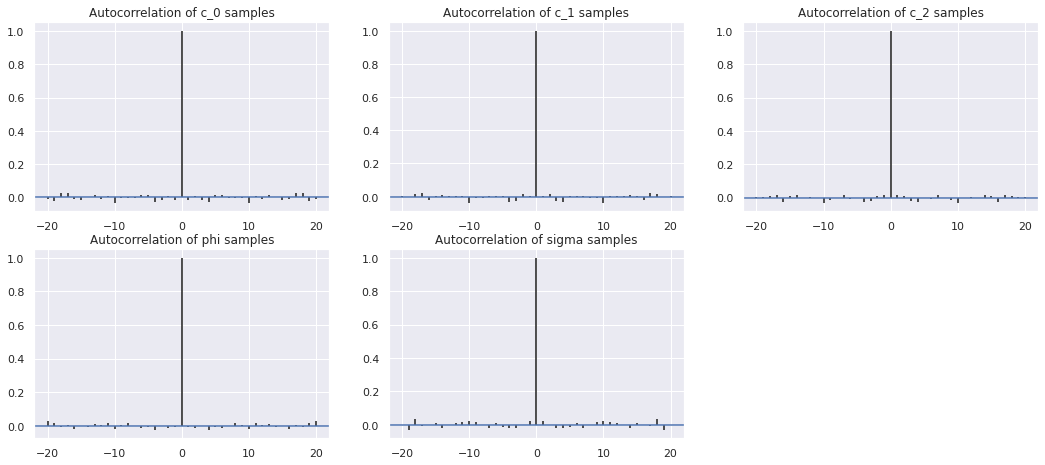

In [50]:
#autocorrelation plots
linear_quadratic_param = ['c_0', 'c_1', 'c_2','phi','sigma']
display_acf_plots(linear_quadratic_samples, linear_quadratic_param)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


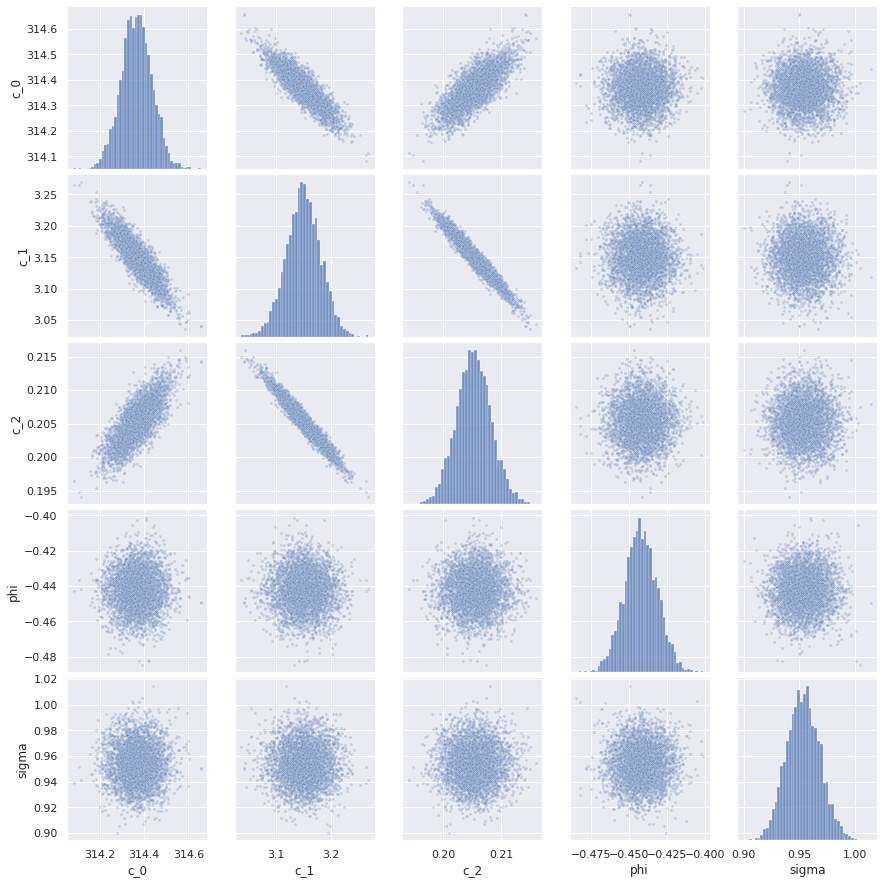

In [51]:
#pair plots
pair_plots(linear_quadratic_samples,linear_quadratic_param)

In [52]:
def linear_quadratic_model_sampler(posterior_samples,time_range,f,args=0):
    return np.array(sts.norm.rvs(f(posterior_samples['c_0'],args) + 
                                 f(posterior_samples['c_1'],args)*(time_range) + 
                                 f(posterior_samples['c_2'],args)*(time_range**2) + 
                                 f(posterior_samples['c_3'],args)*np.cos((2*np.pi*time_range*4) + 
                                 f(posterior_samples['phi'],args)),
                                 np.mean(posterior_samples['sigma'])))

In [53]:
#linear quadratic model sample data
linear_quadratic_mean = linear_quadratic_model_sampler(linear_quadratic_samples,days,np.mean)
linear_quadratic_lower_interval = linear_quadratic_model_sampler(linear_quadratic_samples,days,np.percentile,2.5)
linear_quadratic_upper_interval = linear_quadratic_model_sampler(linear_quadratic_samples,days,np.percentile,97.5)

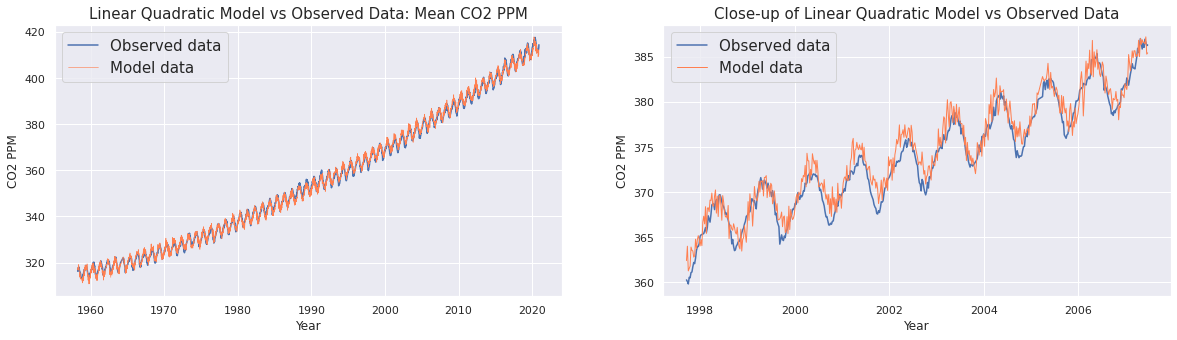

In [147]:
#Plot of linear quadratic model vs observed data
plot_model('Linear Quadratic', linear_quadratic_mean)

In [55]:
linear_quadratic_rep = np.zeros((4000,len(days)))

for i in range(4000):
    linear_quadratic_rep[i,:] = sts.norm.rvs(linear_quadratic_samples['c_0'][i] + 
                                      linear_quadratic_samples['c_1'][i]*(days)+ 
                                      linear_quadratic_samples['c_2'][i]*(days**2)+ 
                                      linear_quadratic_samples['c_3'][i]*np.cos((2*np.pi*days*4) + 
                                      linear_quadratic_samples['phi'][i]),
                                      linear_quadratic_samples['sigma'][i])

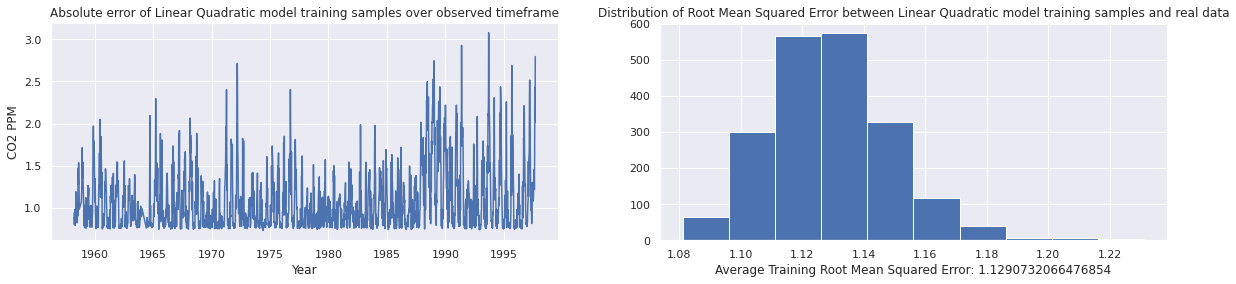

In [148]:
plot_errors_train('Linear Quadratic',linear_quadratic_rep)

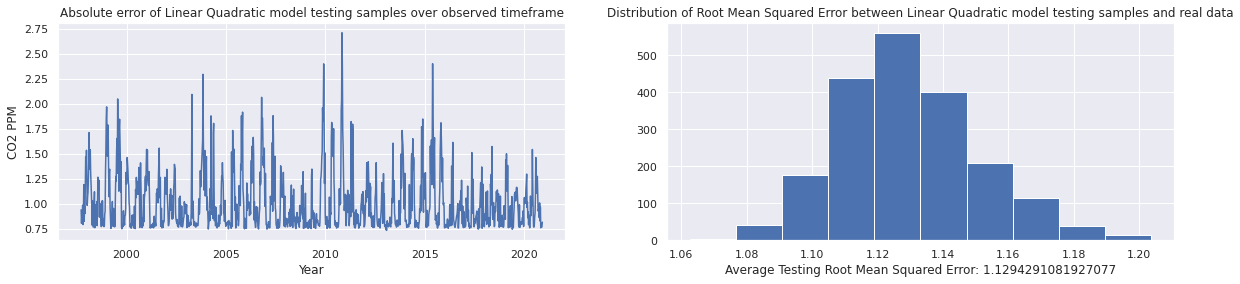

In [149]:
plot_errors_test('Linear Quadratic',linear_quadratic_rep)

# Predictions

In [64]:
import math
#Define update functions to get new values for each new time step
def update_params(old_params, params_std):
    new_params = np.empty(len(old_params))
    for i in range(len(old_params)):
        new_params[i] = sts.norm(loc = old_params[i], scale = params_std[i]).rvs()
    return new_params

def update_xs(day, c_0, c_1, c_2):
    return c_0 + c_1*day + c_2*day**2

def update_ys(x, day, c_3, phi):
    return x + c_3*np.cos(2*math.pi*day*4 + phi) + sts.norm(loc = 0, scale = y_std).rvs()

# The standard deviations for our model parameters (beta, gamma, etc)
# don't change through time, so we define them here (as 0.5 or 0.1% of their respective mean values)
underlying_params_std = np.array([
            abs(np.mean(linear_quadratic_samples['c_1'])*0.005),
            abs(np.mean(linear_quadratic_samples['c_2'])*0.005)])

cos_params_std = np.array([
            abs(np.mean(linear_quadratic_samples['c_3'])*0.001),
            abs(np.mean(linear_quadratic_samples['phi'])*0.001)])

# All samples start at the same initial positions, so we can defined them here also
x_0 = (np.mean(linear_quadratic_samples['c_0']) 
    + np.mean(linear_quadratic_samples['c_1'])*data['Dates'].values[-1] 
    + np.mean(linear_quadratic_samples['c_2'])*np.square(data['Dates'].values[-1]))

y_0 = data['CO2'].values[-1]

n_samples = 500 # number of samples
n_future = 2080 # number of weeks to predict

# Define a time series that starts in 2019 when the original data ended,
# and where each unit equals 4 years
ts = np.arange(n_future + 1)
ts = ts/4/365.25*7 + data['Dates'].values[-1]

# Define arrays that record the evolution of parameter values of every sample at all time steps
underlying_params_history = np.empty((n_samples, n_future + 1, 2))
cos_params_history = np.empty((n_samples, n_future + 1, 2))

# Trend and seasonal predictions for every time step of every sample at all time steps
xs = np.empty((n_samples, n_future + 1))
ys = np.empty((n_samples, n_future + 1))

# Go through n_samples iterations, and define their initial parameter values.
# Each new sample is a different parameter sample from the Stan posterior above
for i in range(n_samples):
    c_0 = linear_quadratic_samples['c_0'][i]
    underlying_params_history[i][0] = np.array([
            linear_quadratic_samples['c_1'][i],
            linear_quadratic_samples['c_2'][i]])
    cos_params_history[i][0] = np.array([
            linear_quadratic_samples['c_3'][i],
            linear_quadratic_samples['phi'][i]])
    y_std = linear_quadratic_samples['sigma'][i]
    xs[i][0] = x_0
    ys[i][0] = y_0
    # Go through n_future time steps, and get the trend and seasonal predictions
    for j in range(1, n_future + 1):
        underlying_params_history[i][j] = update_params(underlying_params_history[i][j-1], underlying_params_std)
        cos_params_history[i][j] = update_params(cos_params_history[i][j-1], cos_params_std)
        xs[i][j] = update_xs(ts[j], c_0, *underlying_params_history[i][j])
        ys[i][j] = update_ys(xs[i][j], ts[j], *cos_params_history[i][j])

In [65]:
intervals = np.empty((n_future + 1, 2))
means = np.empty(n_future + 1)
for i in range(n_future + 1):
    intervals[i] = np.percentile(ys.T[i], [2.5, 97.5])
    means[i] = np.mean(ys.T[i])

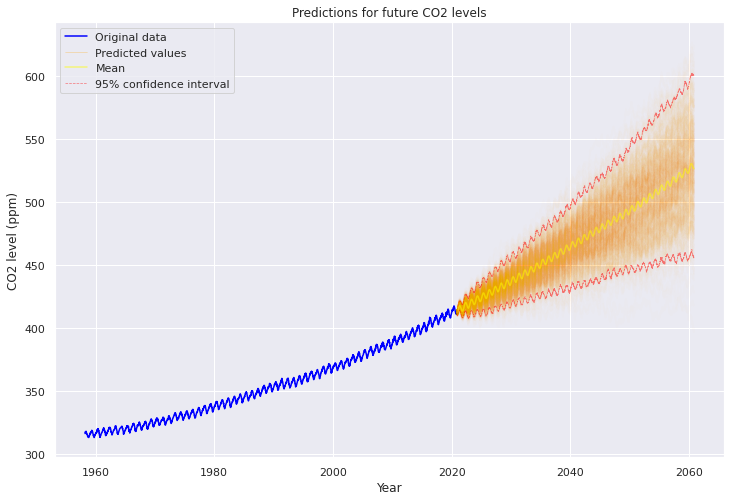

In [93]:
# Show the old data and new predictions on the same plot
plt.figure(figsize=(12,8))
plt.plot(data['Dates']*4+1958.25, data['CO2'], c='blue')
for i in range(n_samples):
    plt.plot(ts*4+1958.25, ys[i], c='orange', alpha=0.01)
plt.plot(ts*4+1958.25, intervals.T[0], c='red', lw=0.7, alpha=0.5, linestyle='--')
plt.plot(ts*4+1958.25, intervals.T[1], c='red', lw=0.7, alpha=0.5, linestyle='--')
plt.plot(ts*4+1958.25, means, alpha=0.5, c='yellow')
lines = [
    Line2D([0], [0], color='blue', linestyle='-'),
    Line2D([0], [0], color='orange', linewidth=0.5, alpha=0.5, linestyle='-'),
    Line2D([0], [0], color='yellow', alpha=0.5, linestyle='-'),
    Line2D([0], [0], color='red', linewidth=0.7, alpha=0.5, linestyle='--')
]
labels = ['Original data', 'Predicted values', 'Mean', '95% confidence interval']
plt.legend(lines, labels)
plt.xlabel('Year')
plt.ylabel('CO2 level (ppm)')
plt.title('Predictions for future CO2 levels')
plt.show()

In [4]:
prob_550 = np.empty(n_future + 1)
for i in range(n_future + 1):
    prob_550[i] = (ys.T[i] > 550).sum()/n_samples
    
plt.figure(figsize=(8,6))
plt.plot(ts*4+1958.25, prob_550)
plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Probability of CO2 levels being higher than 550 ppm')
plt.show()

first_550_ind = np.argmax(prob_550 > 0)
first_550 = ts[first_550_ind]*4+1958.25
print('Hence, the probability of atmospheric CO2 levels reaching 550 PPM crosses 0%% in %d' % first_550)

NameError: ignored